In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
from shapely.geometry import Point, Polygon

from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import plot_moran
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

In [2]:
def get_data_frame(city: str):  # Will have to be changed for Colab
    link_to_data = f"./shp_file/neighbourhoods_{city.title()}-polygon.shp"
    gdf = gpd.read_file(link_to_data)
    attract_df = pd.read_csv("./attractions-merged.csv")
    airbnb_df = pd.read_csv("./airbnb_attractions.csv")
    return gdf, attract_df, airbnb_df

def plot_listings_and_attractions(gdf, attract_df, airbnb_df, city):
    # Get the neighbors 
    neighbor = gdf["neighbourh"].unique()
    neighbor_group = gdf["neighbou_1"].unique()
    # Some city may have no neighbor group at all and that can lead to None results when looking for rows 
    # containing data in a specific city!
    if neighbor_group[0] is not None:
        city_listings = airbnb_df.loc[airbnb_df["neighbourhood_cleansed"].isin(neighbor) & 
    airbnb_df["neighbourhood_group_cleansed"].isin(neighbor_group)]
    else:
        city_listings = airbnb_df.loc[airbnb_df["neighbourhood_cleansed"].isin(neighbor)]
    city_attractions = attract_df.loc[attract_df["City"]==f"{city.title()}"]

    # Compute the average of the distance_to_nearest_attraction in each neighborhood
    gdf["avg_nearest_dist_attr"] = [0.0 for i in range(gdf.shape[0])]
    for i in range(gdf.shape[0]):
        # Get the neighbor. I don't care about efficiency for this part.
        cur_neighbor = gdf.loc[i, "neighbourh"]
        neighbor_listings = city_listings.loc[city_listings["neighbourhood_cleansed"]==cur_neighbor]
        # average for each neighborhood zone.
        gdf.loc[i, "avg_nearest_dist_attr"] = neighbor_listings["distance_to_attraction"].mean()
        gdf.loc[i, "num_listings"] = neighbor_listings.shape[0]
    # Standardized 1/distance * num_listings as weight
    gdf["weighed_standardized"] = 1/gdf["avg_nearest_dist_attr"] * gdf["num_listings"]
    gdf["weighed_standardized"] = (gdf["weighed_standardized"] - gdf["weighed_standardized"].mean()) / gdf["weighed_standardized"].std()

    # Create Points using Longitude and Latitude
    listings_geometry = [Point(xy) for xy in zip(city_listings["longitude"], city_listings["latitude"])]
    attractions_geometry = [Point(xy) for xy in zip(city_attractions["Longitude"], city_attractions["Latitude"])] 
    # ORDER OF ZIP MATTERS!!!
    
    # Create the GeoDataFrame
    crs = {'init':'epsg:4326'}  # May be wrong tho for our case.....
    listings_gdf = gpd.GeoDataFrame(city_listings, #specify our data
                              crs=crs, #specify our coordinate reference system
                              geometry=listings_geometry) #specify the geometry list we created
    attractions_gdf = gpd.GeoDataFrame(attractions_geometry, #specify our data
                              crs=crs, #specify our coordinate reference system
                              geometry=attractions_geometry) #specify the geometry list we created

    # Plot the listings point and the attractions positions
    fig, ax = plt.subplots(figsize=(15,15))
    gdf.plot(ax=ax, color="grey")
    listings_gdf.plot(ax=ax, markersize=20, color='red', marker='o', label="Listings")
    attractions_gdf.plot(ax=ax, markersize=20, color='purple', marker='^', label="Attractions") 
    plt.legend(prop={'size':15})
    # plt.savefig(f"{city}_scatter.png")



In [3]:
def moran_landmark_distance(gdf, has_island):
    # Output both Global Moran and Local Moran (Both Univariate)
    # Make sure gdf has the  attribute weighed_standardized created in plot_listings_and_attractions function!
    # Right now...Remove the neighbors with no listings....
    neighbor_with_listings = gdf
    # Remove islands...Experimental
    if has_island:
        indices = neighbor_with_listings.index.tolist()
        for i in indices:
            L = []
            island = True
            for j in indices:
                if i != j:
                  L.append(neighbor_with_listings.iloc[i].geometry.distance(neighbor_with_listings.iloc[j].geometry))  
            for k in range(len(L)):
                if abs(L[k]) <= 10e-5:
                    neighbor_with_listings.at[i,'island'] = 1
                    island = False
                    break
            if island:
                neighbor_with_listings.at[i,'island']=0
        neighbor_with_listings = neighbor_with_listings[neighbor_with_listings["island"] == 1]        
    neighbor_with_listings = neighbor_with_listings.dropna(subset=["avg_nearest_dist_attr"])
    
    y = neighbor_with_listings["weighed_standardized"].values
    w = Queen.from_dataframe(neighbor_with_listings)
    moran = Moran(y, w)
    moran_stats = moran.I
    print(moran_stats, moran.p_sim)
    # plot_moran(moran, zstandard=True, figsize=(10,4))
    # LISA time
    moran_loc = Moran_Local(y, w, permutations=2000)
    # We finna draw LISA clusters manually now.
    neighbor_with_listings['significant'] = moran_loc.p_sim < 0.05
    neighbor_with_listings['quadrant'] = moran_loc.q
    # Left Outer Join....for some reasons....
    gdf_renewed = pd.merge(gdf, neighbor_with_listings, on=["neighbourh", "neighbou_1", "geometry"], how='left')
    # ok, the join works
    f, ax = plt.subplots(1, figsize=(15, 15))
    # Plot the city shapefile
    gdf_renewed.plot(ax=ax, color="grey")
    # Plot the HH clusters
    hh = gdf_renewed.loc[(gdf_renewed["quadrant"]==1) & (gdf_renewed["significant"]==True), "geometry"]
    if hh.shape[0] != 0:
        hh.plot(ax=ax, color="blue", label="HH Cluster")
    # Plot the LL clusters
    ll = gdf_renewed.loc[(gdf_renewed["quadrant"]==3) & (gdf_renewed["significant"]==True), "geometry"]
    if ll.shape[0] != 0:
        ll.plot(ax=ax, color="red", label="LL Cluster")
    # Plot the LH clusters
    lh = gdf_renewed.loc[(gdf_renewed["quadrant"]==2) & (gdf_renewed["significant"]==True), "geometry"]
    if lh.shape[0] != 0:
        lh.plot(ax=ax, color="orange", label="LH Cluster")
    hl = gdf_renewed.loc[(gdf_renewed["quadrant"]==4) & (gdf_renewed["significant"]==True), "geometry"]
    if hl.shape[0] != 0:
        hl.plot(ax=ax, color="magenta", label="HL Cluster")
    # Manual legend
    legend_elements = [Patch(facecolor="blue", edgecolor="blue", label="HH Cluster"), 
                       Patch(facecolor="red", edgecolor="red", label="LL Cluster"),
                       Patch(facecolor="orange", edgecolor="orange", label="LH Cluster"),
                       Patch(facecolor="magenta", edgecolor="magenta", label="HL Cluster"),
                       Patch(facecolor="grey", edgecolor="grey", label="Not Significant")]
    ax.legend(handles=legend_elements)
    plt.savefig(f"{city[0]}_LISA.png")

Continue with Hypothesis Testing.

City: Barcelona


/tmp/ipykernel_10754/3995478055.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pd.read_csv("/home/hnguyen/Documents/CISC-372/group_proj/airbnb_attractions.csv")
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _pr

0.5960479523646917 0.001

City: Toronto


/tmp/ipykernel_10754/3995478055.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pd.read_csv("/home/hnguyen/Documents/CISC-372/group_proj/airbnb_attractions.csv")
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _pr

0.16843690582129023 0.001

City: Sydney


/tmp/ipykernel_10754/3995478055.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pd.read_csv("/home/hnguyen/Documents/CISC-372/group_proj/airbnb_attractions.csv")
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _pr

0.05408577448461895 0.123



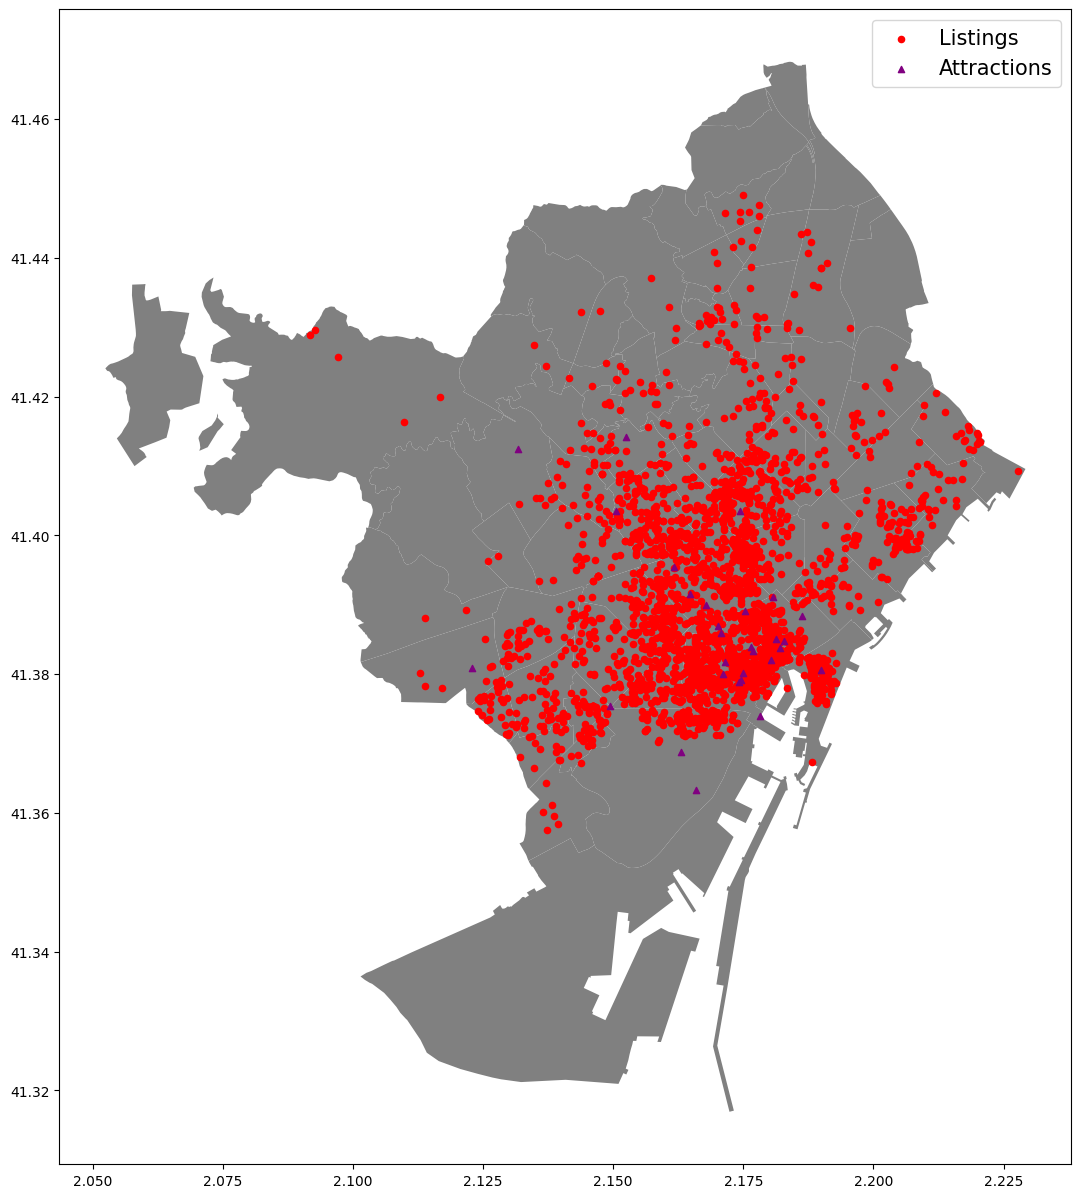

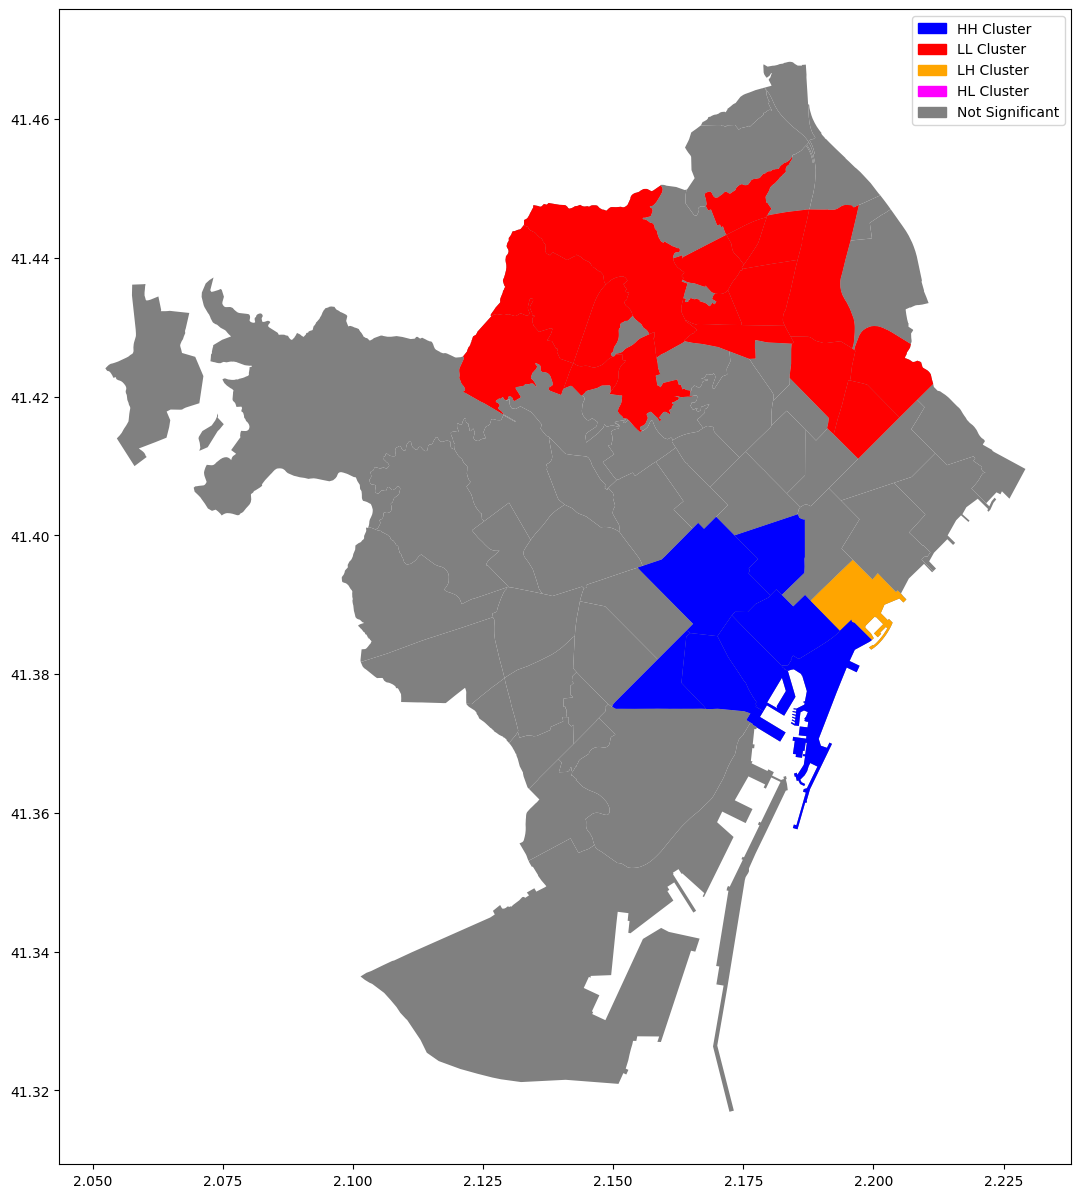

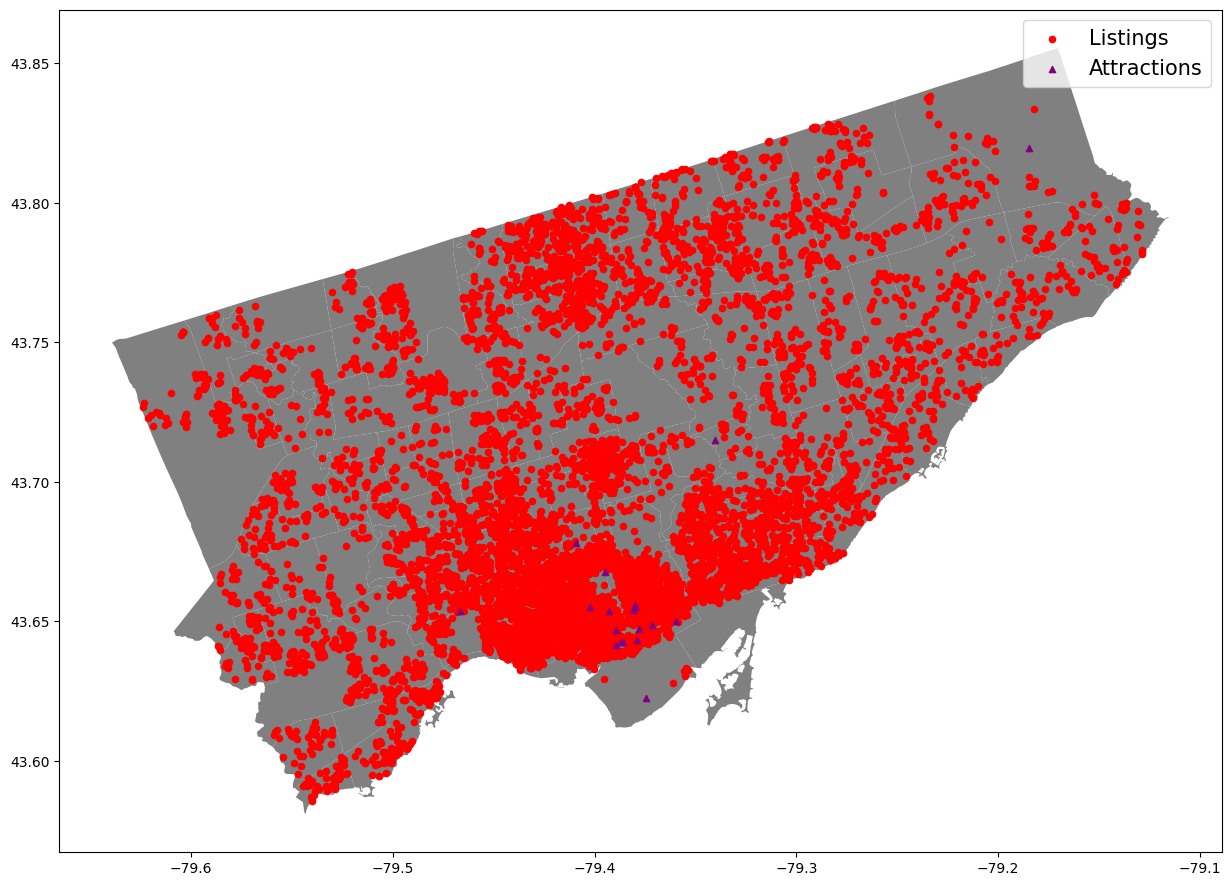

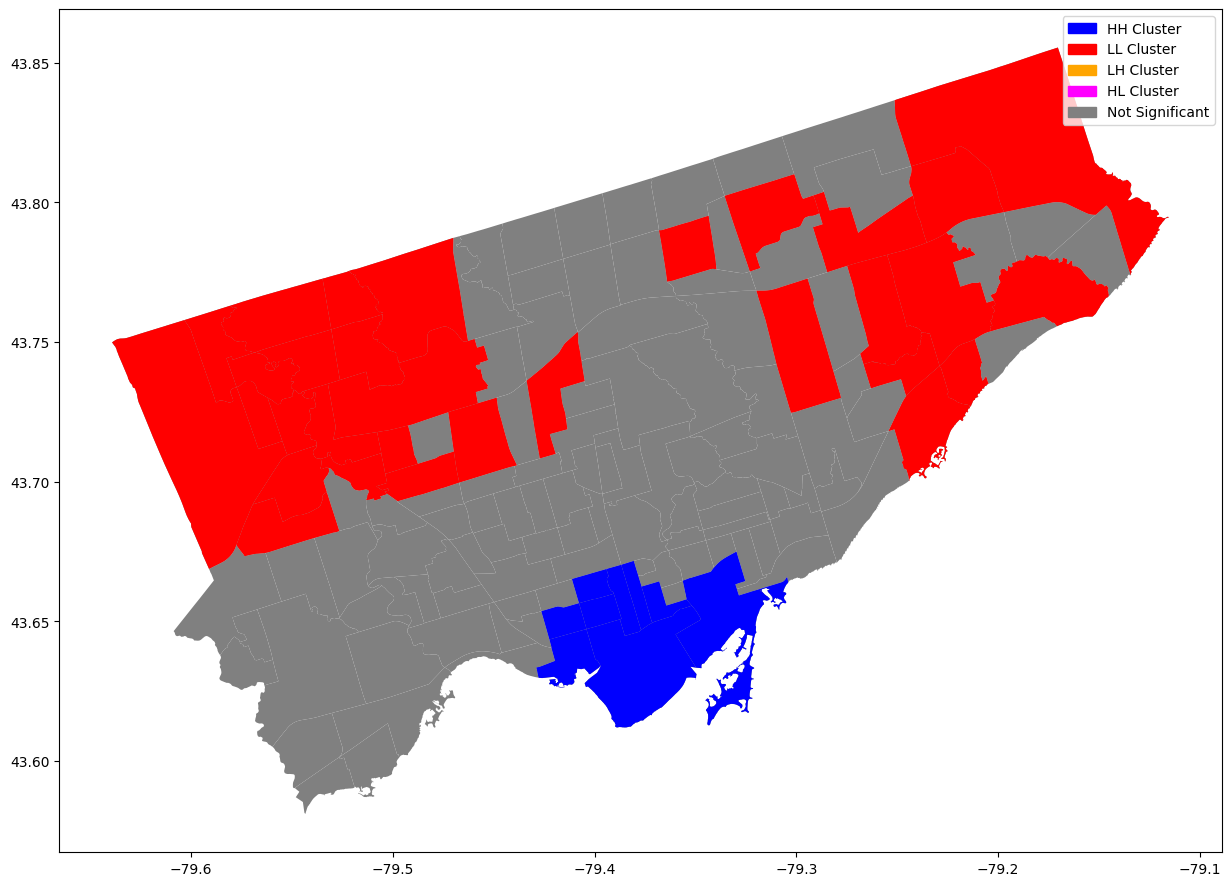

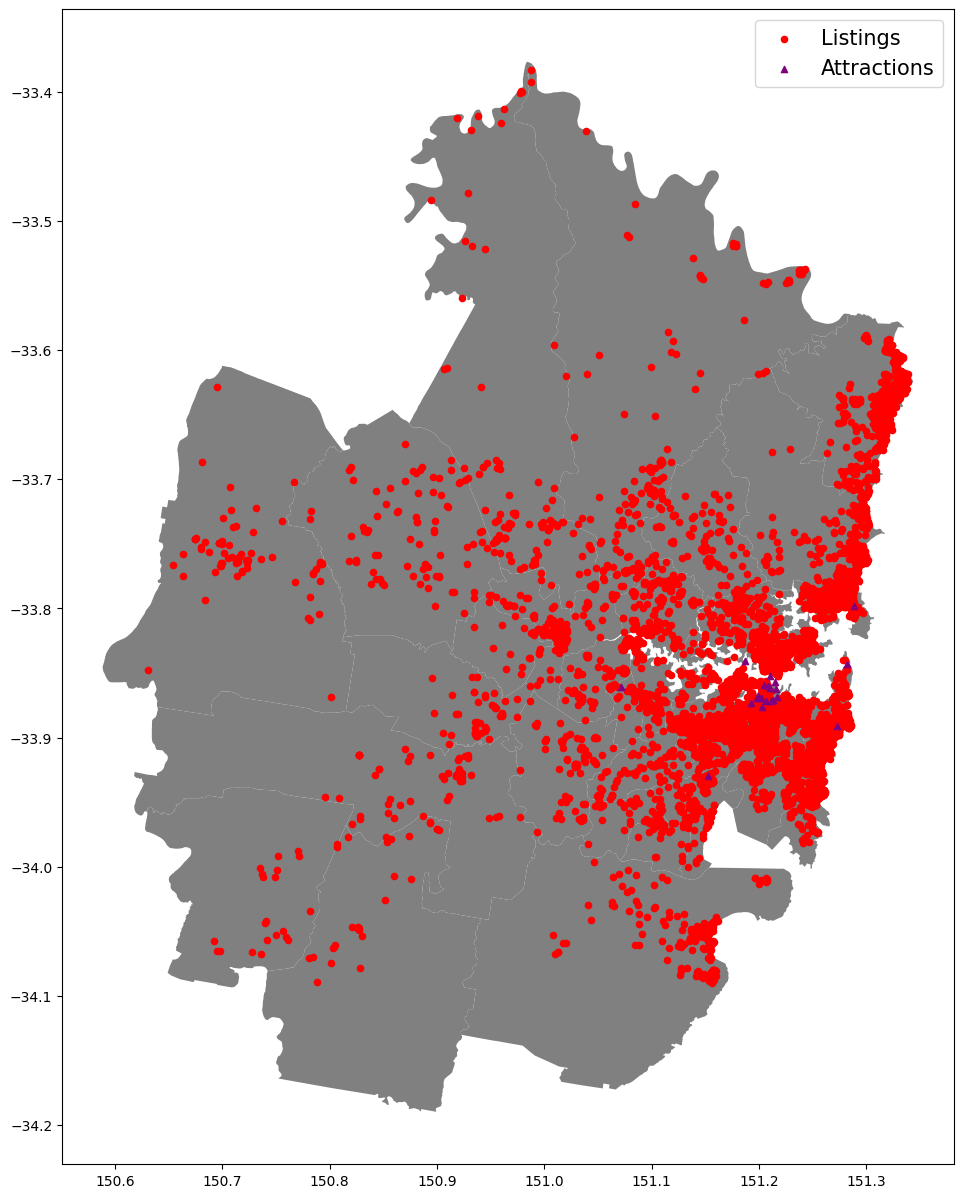

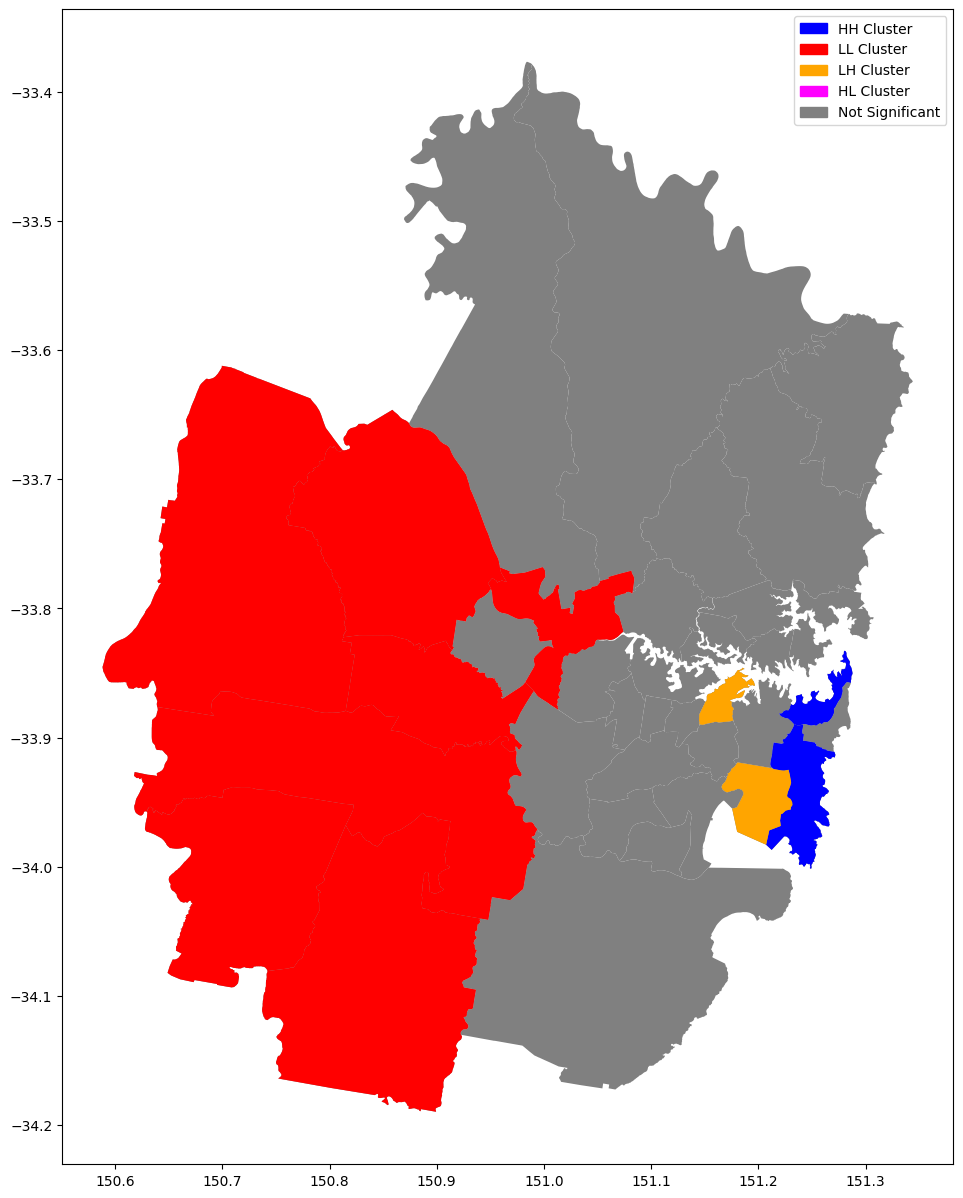

In [326]:
# Test with Barcelona. Format: (<city_name>, has_island)
cities = [("Barcelona", True), ("Toronto", False), ("Sydney", False)]
for city in cities:
    name, has_island = city
    print(f"City: {name.title()}")
    city_gdf, city_attract_df, airbnb_df = get_data_frame(name)
    plot_listings_and_attractions(city_gdf, city_attract_df, airbnb_df, name)  
    moran_landmark_distance(city_gdf, has_island)
    print("")

In [313]:
# name, has_island = ("Toronto", False)
# name, has_island = ("Sydney", False)
name, has_island = ("Barcelona", True)
print(f"City: {name.title()}")
city_gdf, city_attract_df, airbnb_df = get_data_frame(name)

City: Barcelona


/tmp/ipykernel_10754/1793178857.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pd.read_csv("/home/hnguyen/Documents/CISC-372/group_proj/airbnb_attractions.csv")


In [314]:
# plot_listings_and_attractions(city_gdf, city_attract_df, airbnb_df, name)  
# def plot_listings_and_attractions(gdf, attract_df, airbnb_df, city):
# Get the neighbors 
gdf, attract_df, city = city_gdf, city_attract_df, name
neighbor = gdf["neighbourh"].unique()
neighbor_group = gdf["neighbou_1"].unique()
# Some city may have no neighbor group at all and that can lead to None results when looking for rows 
# containing data in a specific city!
if neighbor_group[0] is not None:
    city_listings = airbnb_df.loc[airbnb_df["neighbourhood_cleansed"].isin(neighbor) & 
airbnb_df["neighbourhood_group_cleansed"].isin(neighbor_group)]
else:
    city_listings = airbnb_df.loc[airbnb_df["neighbourhood_cleansed"].isin(neighbor)]
city_attractions = attract_df.loc[attract_df["City"]==f"{city.title()}"]

# Compute the average of the distance_to_nearest_attraction in each neighborhood
gdf["avg_nearest_dist_attr"] = [0.0 for i in range(gdf.shape[0])]
for i in range(gdf.shape[0]):
    # Get the neighbor. I don't care about efficiency for this part.
    cur_neighbor = gdf.loc[i, "neighbourh"]
    neighbor_listings = city_listings.loc[city_listings["neighbourhood_cleansed"]==cur_neighbor]
    # average for each neighborhood zone.
    gdf.loc[i, "avg_nearest_dist_attr"] = neighbor_listings["distance_to_attraction"].mean()
    gdf.loc[i, "num_listings"] = neighbor_listings.shape[0]
# Standardized distance * num_listings as weight
#gdf["weighed_standardized"] = (1/(((gdf["avg_nearest_dist_attr"] - gdf["avg_nearest_dist_attr"].mean()) / gdf["avg_nearest_dist_attr"]).std())) * gdf["num_listings"]
# DOESN'T WORK gdf["weighed_standardized"] = (1 / gdf["avg_nearest_dist_attr"]) * (((gdf["num_listings"] - gdf["num_listings"].mean()) / gdf["num_listings"]).std())
gdf["weighed_standardized"] = 1/gdf["avg_nearest_dist_attr"] * gdf["num_listings"]
idx = gdf.groupby('weighed_standardized')['weighed_standardized'].idxmax()
gdf["weighed_standardized"] = (gdf["weighed_standardized"] - gdf["weighed_standardized"].mean()) / gdf["weighed_standardized"].std()
max_scores = gdf.loc[idx] # Sydney score way too big lmaooo
max_scores

,neighbourh,neighbou_1,geometry,avg_nearest_dist_attr,num_listings,weighed_standardized
42,Montbau,Horta-Guinardó,"POLYGON ((2.13628 41.44274, 2.13630 41.44273, ...",2.124111,1.0,-0.426578
45,la Vall d'Hebron,Horta-Guinardó,"POLYGON ((2.15213 41.43090, 2.15192 41.43065, ...",2.055134,1.0,-0.426508
56,la Prosperitat,Nou Barris,"POLYGON ((2.17632 41.43859, 2.17488 41.43840, ...",3.832429,2.0,-0.426350
39,la Font d'en Fargues,Horta-Guinardó,"POLYGON ((2.17183 41.42400, 2.17191 41.42317, ...",1.222551,1.0,-0.425028
52,la Guineueta,Nou Barris,"POLYGON ((2.17422 41.43992, 2.17430 41.43983, ...",3.068260,3.0,-0.424314
...,...,...,...,...,...,...
5,la Barceloneta,Ciutat Vella,"POLYGON ((2.19642 41.38351, 2.19542 41.38190, ...",0.234658,88.0,1.246303
0,el Raval,Ciutat Vella,"POLYGON ((2.17737 41.37532, 2.17852 41.37481, ...",0.305684,226.0,2.873496
2,la Dreta de l'Eixample,Eixample,"POLYGON ((2.17091 41.40182, 2.17332 41.39999, ...",0.422938,321.0,2.961265
6,"Sant Pere, Santa Caterina i la Ribera",Ciutat Vella,"POLYGON ((2.18346 41.39061, 2.18460 41.38976, ...",0.176818,164.0,3.713998


/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/hnguyen/372_Stuff/lib64/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


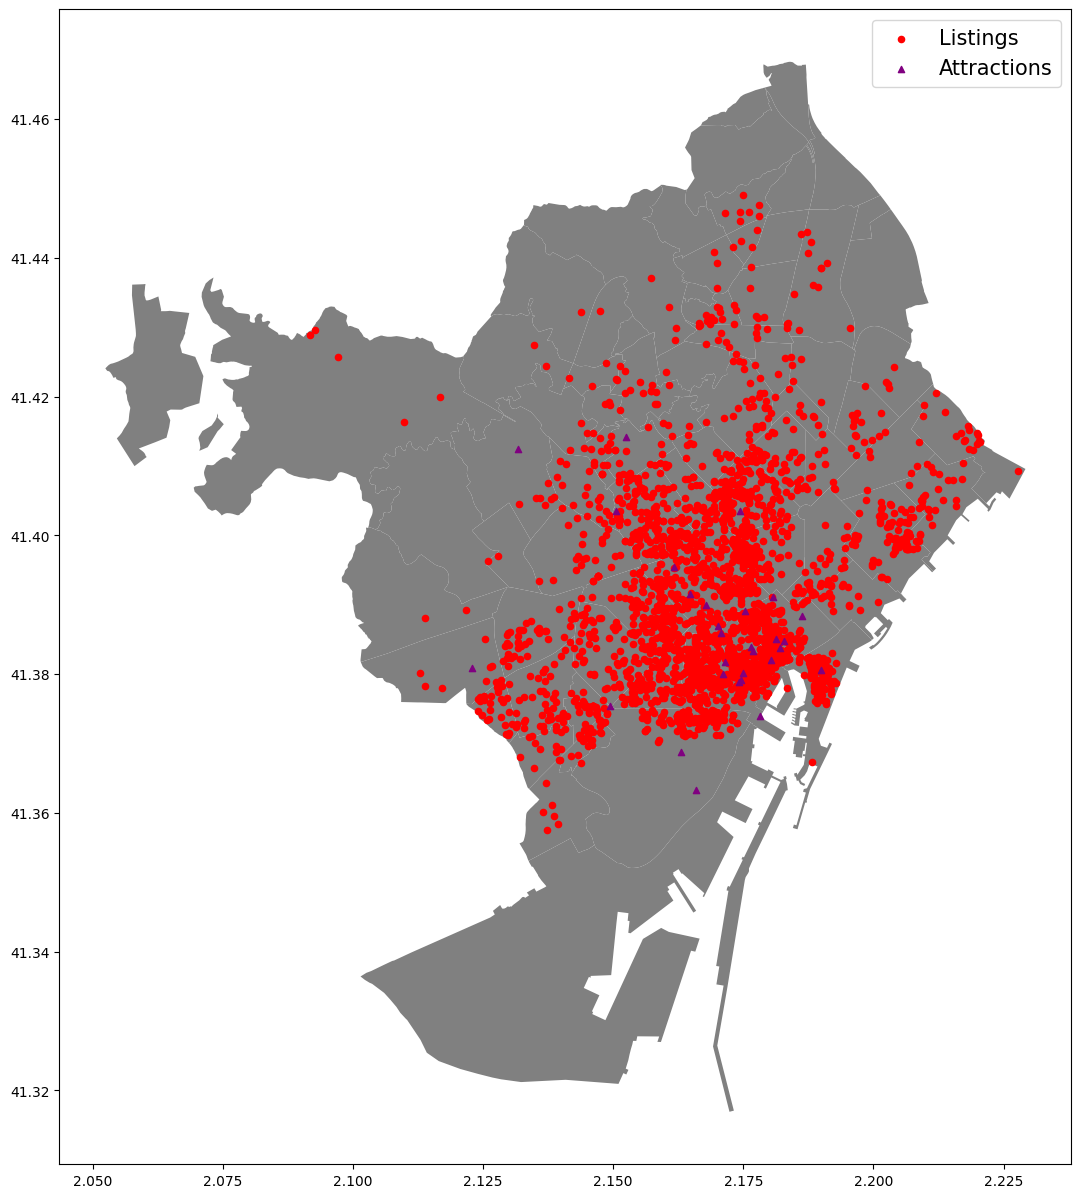

In [315]:
# Create Points using Longitude and Latitude
listings_geometry = [Point(xy) for xy in zip(city_listings["longitude"], city_listings["latitude"])]
attractions_geometry = [Point(xy) for xy in zip(city_attractions["Longitude"], city_attractions["Latitude"])] 
# ORDER OF ZIP MATTERS!!!

# Create the GeoDataFrame
crs = {'init':'epsg:4326'}  # May be wrong tho for our case.....
listings_gdf = gpd.GeoDataFrame(city_listings, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=listings_geometry) #specify the geometry list we created
attractions_gdf = gpd.GeoDataFrame(attractions_geometry, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=attractions_geometry) #specify the geometry list we created

# Plot the listings point and the attractions positions
fig, ax = plt.subplots(figsize=(15,15))
gdf.plot(ax=ax, color="grey")
listings_gdf.plot(ax=ax, markersize=20, color='red', marker='o', label="Listings")
attractions_gdf.plot(ax=ax, markersize=20, color='purple', marker='^', label="Attractions") 
plt.legend(prop={'size':15})

/tmp/ipykernel_10754/3303691114.py:26: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(neighbor_with_listings)


0.5960479523646917 0.001


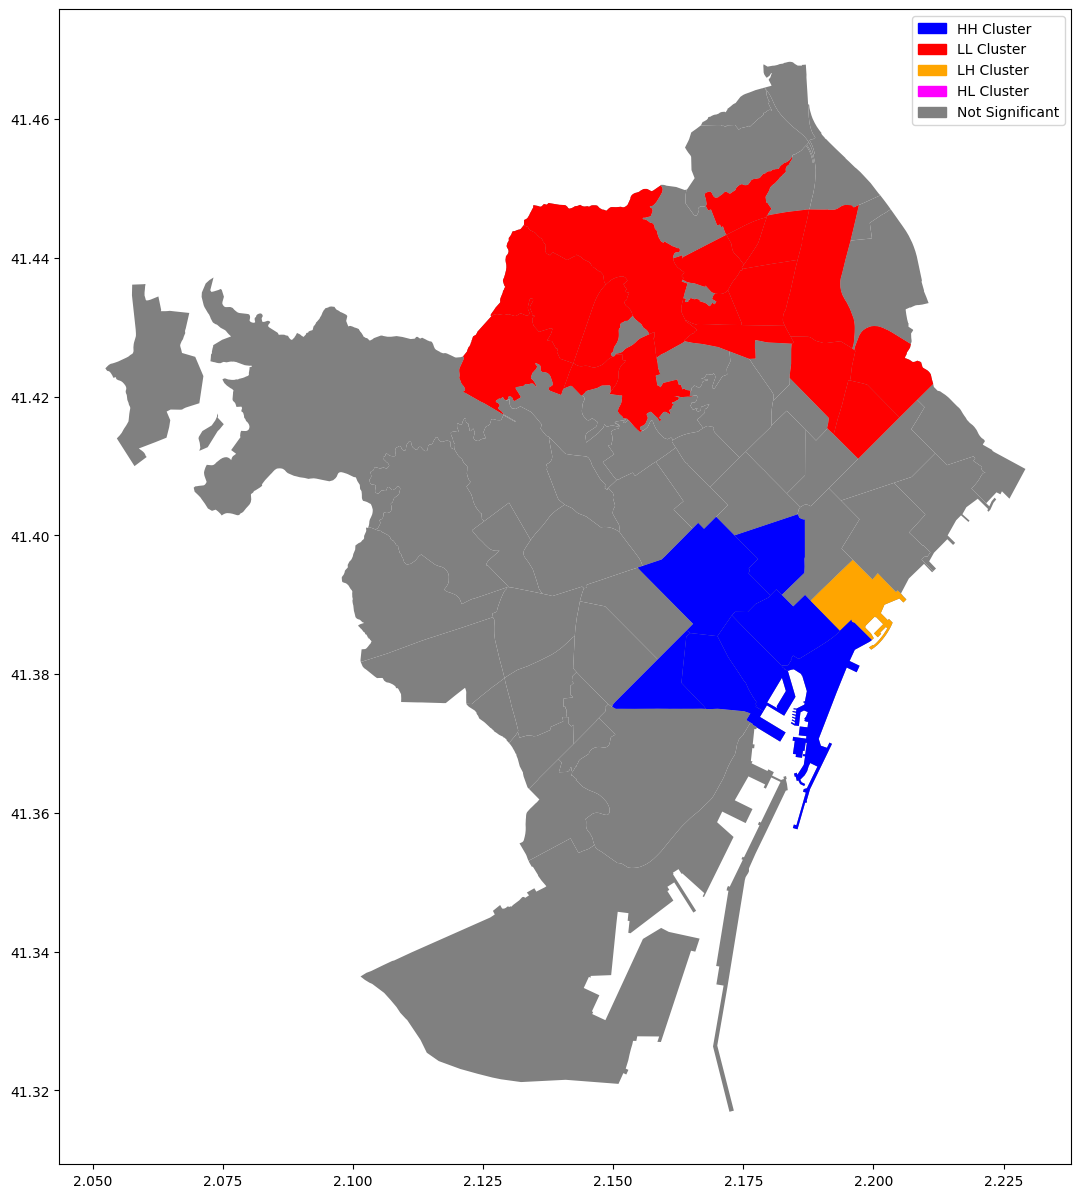

In [316]:
moran_landmark_distance(city_gdf, has_island)